In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import numpy as np
from PIL import Image
import re
from sklearn.model_selection import train_test_split, KFold
from skimage.transform import resize
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model, load_model

from src.custom_dataset import CustomDataset
from src.model_unet import ModelUnet
import os
import pandas as pd

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from src.model_trainer import ModelTrainer



/home/bsuetcueoglu/thesiscodegithubclone/mastersthesis/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-21 17:12:46.542952: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 17:12:46.589990: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-21 17:12:47.394917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:

[]


2025-04-21 17:12:48.540072: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


#### Preparing dataset

In [2]:
dataset_images_dir = "../Data/Tool_dataset/images/"
dataset_masks_dir = "../Data/Tool_dataset/masks/" 
dataset_binary_masks_dir = "../Data/Tool_dataset/binary_masks/"

dataset = CustomDataset(dataset_images_dir, dataset_masks_dir, dataset_binary_masks_dir)

Image shape:  (1144, 2392, 3)
Mask shape:  (1144, 2392)


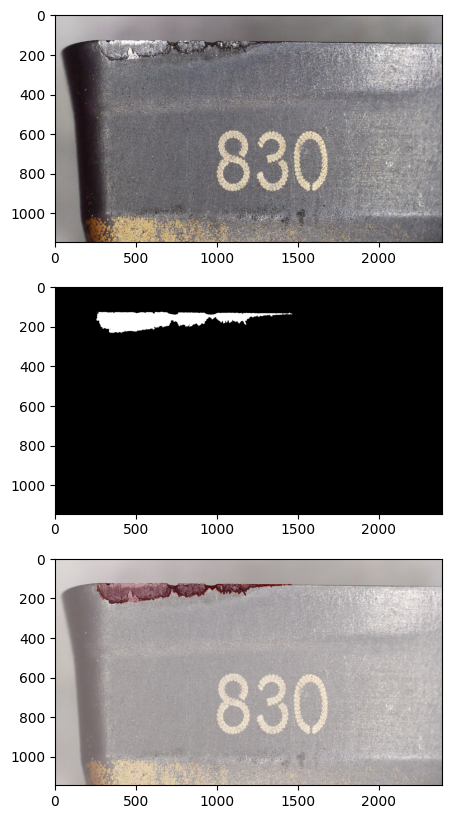

In [3]:
CustomDataset.image_display(dataset.image_paths, dataset.binary_mask_paths, 100)

#### 2. Data Preprocess: Data Augmentation

In [4]:
aug_images = dataset.image_paths
aug_masks = dataset.binary_mask_paths

train_dataframe = CustomDataset.create_df(dataset.image_paths, dataset.binary_mask_paths)
df = train_dataframe
display(df)

,filename,mask
0,../Data/Tool_dataset/images/11_1_2.png,../Data/Tool_dataset/binary_masks/11_1_2_mask.png
1,../Data/Tool_dataset/images/14_1_3.png,../Data/Tool_dataset/binary_masks/14_1_3_mask.png
2,../Data/Tool_dataset/images/11_1_1.png,../Data/Tool_dataset/binary_masks/11_1_1_mask.png
3,../Data/Tool_dataset/images/10_2_1.png,../Data/Tool_dataset/binary_masks/10_2_1_mask.png
4,../Data/Tool_dataset/images/10_4_2.png,../Data/Tool_dataset/binary_masks/10_4_2_mask.png
...,...,...
101,../Data/Tool_dataset/images/13_3_2.png,../Data/Tool_dataset/binary_masks/13_3_2_mask.png
102,../Data/Tool_dataset/images/14_1_4.png,../Data/Tool_dataset/binary_masks/14_1_4_mask.png
103,../Data/Tool_dataset/images/11_3_2.png,../Data/Tool_dataset/binary_masks/11_3_2_mask.png
104,../Data/Tool_dataset/images/11_2_2.png,../Data/Tool_dataset/binary_masks/11_2_2_mask.png


##### Data Augmentation

In [5]:
train_generator_args = dict(rotation_range=0.15,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

height = 256
width = 256
channel = 3

# To visualize the results of generator: set save_to_dir = "your path"
aug_img_dir = "../Data/Tool_dataset/augmented_images/"
aug_mask_dir = "../Data/Tool_dataset/augmented_masks/"
os.makedirs(aug_img_dir, exist_ok=True)
os.makedirs(aug_mask_dir, exist_ok=True)
aug_img_prefix = "aug_"
aug_mask_prefix = "aug_"
aug_format = "png"

#### 3. Transfer Learning with UNet

In [6]:
input_shape = (height, width, channel)
K.clear_session()
unet_model = ModelUnet.TL_unet_model(input_shape)

(None, 16, 16, 512)
(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 128)
(None, 256, 256, 64)
(None, 256, 256, 1)


In [7]:
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 25,854,657 (98.63 MB)

 Trainable params: 11,139,969 (42.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
layers = [(layer, layer.name, layer.trainable) for layer in unet_model.layers]
unet_model_df = pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])

display(unet_model_df)

,Layer Type,Layer Name,Layer Trainable
0,"<InputLayer name=input_layer, built=True>",input_layer,False
1,"<Conv2D name=block1_conv1, built=True>",block1_conv1,False
2,"<Conv2D name=block1_conv2, built=True>",block1_conv2,False
3,"<MaxPooling2D name=block1_pool, built=True>",block1_pool,False
4,"<Conv2D name=block2_conv1, built=True>",block2_conv1,False
5,"<Conv2D name=block2_conv2, built=True>",block2_conv2,False
6,"<MaxPooling2D name=block2_pool, built=True>",block2_pool,False
7,"<Conv2D name=block3_conv1, built=True>",block3_conv1,False
8,"<Conv2D name=block3_conv2, built=True>",block3_conv2,False
9,"<Conv2D name=block3_conv3, built=True>",block3_conv3,False


#### Training the transfer learning U-Net Model

In [9]:
kf = KFold(n_splits=5, shuffle=True)
for k, (train_index, text_index) in enumerate(kf.split(df)):
    train_df = df.iloc[train_index]
    test_df = df.iloc[text_index]

print("Training dataset:")
display(train_df)
print
print("Validation and testing dataset:")
display(test_df)    
test_df.shape

Training dataset:


,filename,mask
0,../Data/Tool_dataset/images/11_1_2.png,../Data/Tool_dataset/binary_masks/11_1_2_mask.png
1,../Data/Tool_dataset/images/14_1_3.png,../Data/Tool_dataset/binary_masks/14_1_3_mask.png
2,../Data/Tool_dataset/images/11_1_1.png,../Data/Tool_dataset/binary_masks/11_1_1_mask.png
3,../Data/Tool_dataset/images/10_2_1.png,../Data/Tool_dataset/binary_masks/10_2_1_mask.png
5,../Data/Tool_dataset/images/13_5_4.png,../Data/Tool_dataset/binary_masks/13_5_4_mask.png
...,...,...
100,../Data/Tool_dataset/images/4_1_1.png,../Data/Tool_dataset/binary_masks/4_1_1_mask.png
101,../Data/Tool_dataset/images/13_3_2.png,../Data/Tool_dataset/binary_masks/13_3_2_mask.png
102,../Data/Tool_dataset/images/14_1_4.png,../Data/Tool_dataset/binary_masks/14_1_4_mask.png
103,../Data/Tool_dataset/images/11_3_2.png,../Data/Tool_dataset/binary_masks/11_3_2_mask.png


Validation and testing dataset:


,filename,mask
4,../Data/Tool_dataset/images/10_4_2.png,../Data/Tool_dataset/binary_masks/10_4_2_mask.png
16,../Data/Tool_dataset/images/9_3_4.png,../Data/Tool_dataset/binary_masks/9_3_4_mask.png
27,../Data/Tool_dataset/images/12_2_4.png,../Data/Tool_dataset/binary_masks/12_2_4_mask.png
34,../Data/Tool_dataset/images/13_6_3.png,../Data/Tool_dataset/binary_masks/13_6_3_mask.png
37,../Data/Tool_dataset/images/12_5_2.png,../Data/Tool_dataset/binary_masks/12_5_2_mask.png
38,../Data/Tool_dataset/images/12_5_4.png,../Data/Tool_dataset/binary_masks/12_5_4_mask.png
39,../Data/Tool_dataset/images/12_3_2.png,../Data/Tool_dataset/binary_masks/12_3_2_mask.png
55,../Data/Tool_dataset/images/11_7_2.png,../Data/Tool_dataset/binary_masks/11_7_2_mask.png
56,../Data/Tool_dataset/images/13_6_1.png,../Data/Tool_dataset/binary_masks/13_6_1_mask.png
58,../Data/Tool_dataset/images/10_7_1.png,../Data/Tool_dataset/binary_masks/10_7_1_mask.png


(21, 2)

#### Model training

In [10]:
batch_size = 20
epochs = 80
model_dir = "V_Unet/model_v1_real/"

history, checkpoint_path = ModelTrainer.train_model(df, train_df, test_df, unet_model, 
                    batch_size, epochs, 
                    train_generator_args,aug_img_dir, aug_mask_dir, aug_img_prefix, aug_mask_prefix, aug_format, 
                    height, width,
                    model_dir)

Model input shape: (None, 256, 256, 3)
Found 85 validated image filenames.
Found 85 validated image filenames.
x_batch shape: (20, 256, 256, 3)
y_batch shape: (20, 256, 256, 1)
Epoch 1/80


/home/bsuetcueoglu/thesiscodegithubclone/mastersthesis/venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.9775 - dice_coef: 0.0261 - iou: 0.0132 - loss: -0.0264Found 21 validated image filenames.
Found 21 validated image filenames.

Epoch 1: val_loss improved from inf to -0.03295, saving model to V_Unet/model_v1_real/tool_dataset.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - binary_accuracy: 0.9779 - dice_coef: 0.0259 - iou: 0.0131 - loss: -0.0262 - val_binary_accuracy: 0.9780 - val_dice_coef: 0.0330 - val_iou: 0.0168 - val_loss: -0.0330
Epoch 2/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9764 - dice_coef: 0.0332 - iou: 0.0169 - loss: -0.0326
Epoch 2: val_loss improved from -0.03295 to -0.04041, saving model to V_Unet/model_v1_real/tool_dataset.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - binary_accuracy: 0.9766 - dice_coef: 0.0333 - iou: 0.0169 - loss: -0.0327 - val_binary_accuracy: 0.9775 - val_dice_coef: 0.0404 - val_iou: 0.0206 - val_loss: -0.0404
Epoch 3/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.

In [11]:
metrics, histories = ModelTrainer.evaluate_model_on_val(checkpoint_path, test_df, batch_size, height, width, history)

Found 21 validated image filenames.
Found 21 validated image filenames.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - binary_accuracy: 0.9951 - dice_coef: 0.8718 - iou: 0.7728 - loss: -0.8718
Evaluation scores from pretrained model:
Accuracy:  [('binary_accuracy', 0.9950515627861023)]
Loss:  [('loss', -0.8718098402023315)]
Dice coefficient:  [('dice_coef', 0.8718098402023315)]
IOU:  [('iou', 0.7727546691894531)]


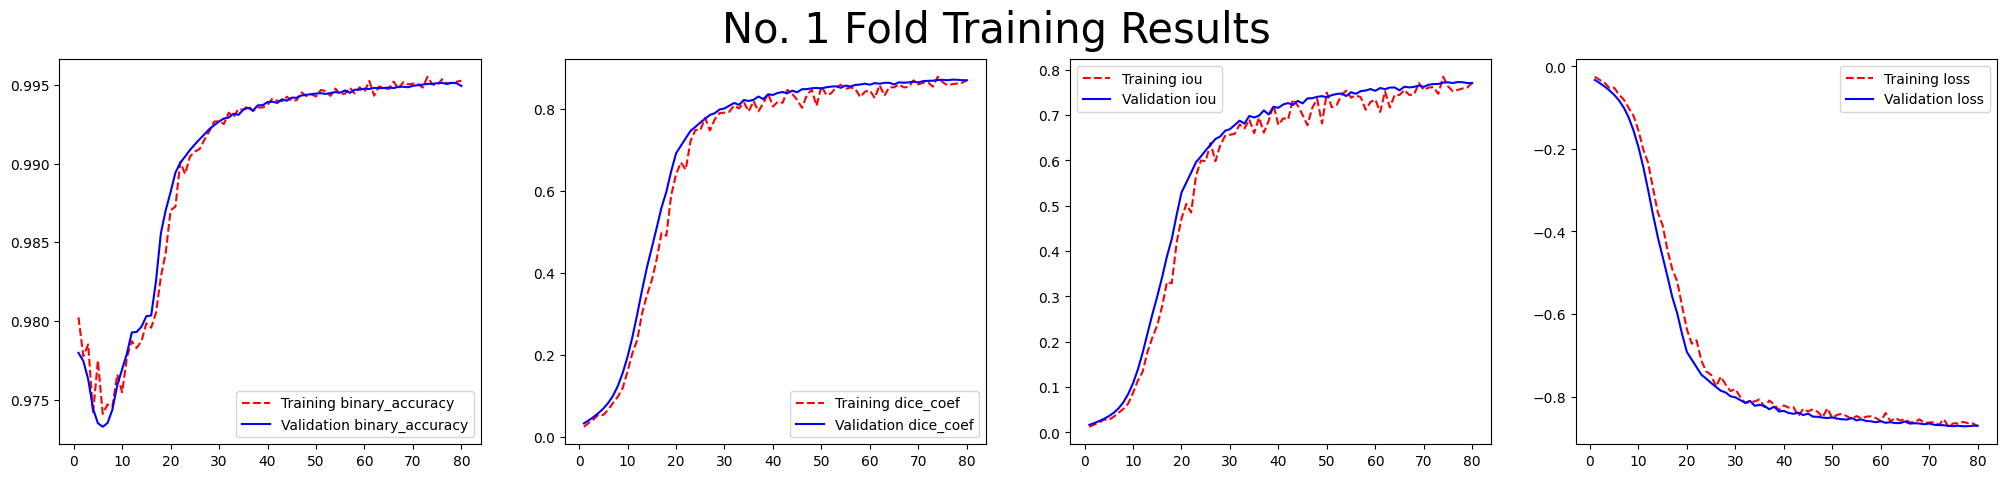

In [12]:
from src.validation_and_prediction import ValidationAndPrediction

# save_dir = 'V_Unet/model_v1_real_and_gen20_2/'
ValidationAndPrediction.plot_histories(histories, model_dir)